In [98]:
!pip install opendatasets --upgrade --quiet

In [99]:
import torch
import os
import opendatasets as od
import torch
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage
import cv2

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
from torchvision.utils import save_image
from torch.utils.data import random_split

from tqdm.notebook import tqdm
import torch.nn.functional as F

%matplotlib inline

In [100]:
# check GPU and set device
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [101]:
# Download Dataset from Kaggle
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in ".\animefacedataset" (use force=True to force download)


In [102]:
# Load Dataset
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [103]:
# Printing the first 5 images
print(os.listdir(DATA_DIR+'/images')[:5])

# Printing the total number of images
print('Total images:', len(os.listdir(DATA_DIR+'/images')))

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg']
Total images: 63565


In [104]:
# # Set folder path
# folder_path = DATA_DIR+'/images'

# # Initialize variables to store total width and height
# total_width = 0
# total_height = 0

# # Count the number of images in the folder
# num_images = 0

# # Loop through all the files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         # Open the image file
#         with PILImage.open(os.path.join(folder_path, filename)) as img:
#             # Add the width and height of the image to the total
#             total_width += img.width
#             total_height += img.height
#             # Increment the image count
#             num_images += 1

# # Calculate the average width and height
# avg_width = total_width / num_images
# avg_height = total_height / num_images

# # Print the results
# print("Average width: ", avg_width)
# print("Average height: ", avg_height)

In [105]:
# Image transforms to convert images into tensors and normalize them
image_size = 64
batch_size = 50 # Batch size
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  # Normalizing, mean and std in RGB channels

print('Image size:', image_size)

Image size: 64


In [106]:
# Load all data for training
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=5, pin_memory=True) # num_workers: number of processes to use for parallelization, pin_memory: copy Tensors into CUDA memory before returning them


In [107]:
# Denormalize images, so that they look normal for display
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] # stats[1][0] is std, stats[0][0] is mean

# Display Images
def show_images(images, nmax=18):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=6).permute(1, 2, 0))

# Show a Batch
def show(dl, nmax=18):
    for images, _ in dl:
        show_images(images, nmax)
        break

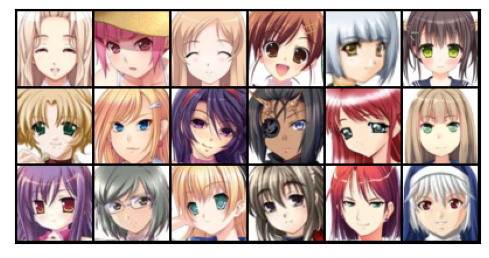

In [108]:
# Displaying a one batch of images
show(train_dl)

In [109]:
# Move tensors to Device (GPU)
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Move batches to Device (GPU)
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
   
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [110]:
device # Check device

device(type='cuda')

In [111]:
train_dl = DeviceDataLoader(train_dl, device) # Load data to device (GPU)
train_dl

In [112]:
# Discriminator: a convolutional neural network that takes an image as input and predicts if it is a real or fake image, i.e. it outputs a number between 0 and 1
# Leaky ReLU: a modified version of the ReLU function that does not set negative values to 0, but instead multiplies them by a small number (0.01), kind of linear function
discriminator = nn.Sequential(
    # input dimension: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # output dimension: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # output dimension: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # output dimension: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # output dimension: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # output dimension: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [113]:
# set the discriminator model to the device
discriminator = to_device(discriminator, device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [114]:
# latent space vector: a vector of numbers that represents a fake image, it is used as input to the generator
latent_size = 128 # size of the latent space vector.

In [115]:
# Generator: a convolutional neural network that takes a latent vector as input and outputs a fake image, i.e. it converts a 1 x 1 x latent_size tensor into a 3 x 64 x 64 image
generator = nn.Sequential(
    # input dimension: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output dimension: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output dimension: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output dimension: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output dimension: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # output dimension: 3 x 64 x 64
)

In [116]:
# Set the generator model to the device
generator = to_device(generator, device)
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([50, 3, 64, 64])


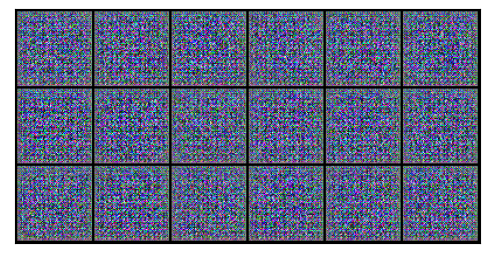

In [117]:
LV = torch.randn(batch_size, latent_size, 1, 1) # random latent
LV = to_device(LV, device) # move the latent tensors to the device
random_fake_images = generator(LV) # generated images

print(random_fake_images.shape) # shape of the generated images
fake_images = to_device(random_fake_images, 'cpu') # move the generated images to the device, CPU because we are going to display them

show_images(fake_images) # displaying the generated images

In [118]:
# Train the Discriminator
def train_discriminator(real_images, d_opt):

    # Clear gradients
    d_opt.zero_grad()

    # Real images to discriminator
    real_predictions = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # loss function: binary cross entropy because we are predicting if the image is real or fake
    real_score = torch.mean(real_predictions).item() # mean of the predictions
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # random latent
    fake_images = generator(latent)

    # Fake images to discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_predictions = discriminator(fake_images) # predictions of the discriminator
    fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets) # loss function: binary cross entropy because we are predicting if the image is real or fake
    fake_score = torch.mean(fake_predictions).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward() # backpropagation
    d_opt.step() # update weights

    return loss.item(), real_score, fake_score

In [119]:
# Train the Generator
def train_generator(g_opt):

    # Clear gradients
    g_opt.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    predictions = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(predictions, targets)
    
    # Update generator weights
    loss.backward()
    g_opt.step()
    
    return loss.item()

In [120]:
sample_dir = 'Generated Images'
os.makedirs(sample_dir, exist_ok=True)

In [121]:
def save_samples(index, latent_tensors, show):

    fake_images = generator(latent_tensors)
    fake_fname = 'generated-{0:0=4d}.png'.format(index)

    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=6).permute(1, 2, 0))

In [122]:
# fixed latent vectors to see how the generator output evolves during training
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([50, 128, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-0000.png


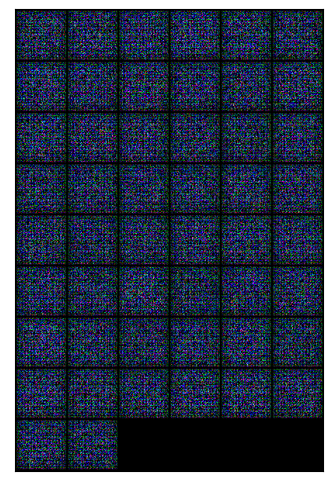

In [123]:
# Training the Model
save_samples(0, fixed_latent, show=True) # show the generated images before training

In [124]:
def discriminator_loss(generator, discriminator, real_images, device):
    batch_size = real_images.size(0)

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Compute the discriminator loss on real and fake images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(batch_size, 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros(batch_size, 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    # Compute the total loss
    loss = real_loss + fake_loss

    return loss


In [125]:
# make model directory to save the model checkpoints
model_dir = 'Saved Models'
os.makedirs(model_dir, exist_ok=True)

In [126]:
# set the learning rate, number of epochs, and the starting epoch
def fit(epochs, learning_rate):

    # empty cache
    torch.cuda.empty_cache()
    
    # Losses & scores
    g_losses = []
    d_losses = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0, 0.9))
    g_opt = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0, 0.9))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator first
            loss_d, real_score, fake_score = train_discriminator(real_images, d_opt)

            # Train generator next
            loss_g = train_generator(g_opt)
            
        # Losses and Scores
        g_losses.append(loss_g)
        d_losses.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.5f}, loss_d: {:.5f}, real_score: {:.5f}, fake_score: {:.5f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        save_samples(epoch+1, fixed_latent, show=False)

        # make directory inside saved models according to epochs to save the model checkpoints
        # make folder of epoch number

        model_dir = 'Saved Models/epoch-{}'.format(epoch+1)
        
        os.makedirs(model_dir, exist_ok=True)
        

        # model_path = os.path.join(model_dir, 'epoch-{}.ckpt'.format(epoch+1))
        # torch.save({
        #     'epoch': epoch,
        #     'generator_state_dict': generator.state_dict(),
        #     'discriminator_state_dict': discriminator.state_dict(),
        #     'g_opt': g_opt.state_dict(),
        #     'd_opt': d_opt.state_dict(),
        #     'loss_g': loss_g,
        #     'loss_d': loss_d,
        #     'real_score': real_score,
        #     'fake_score': fake_score
        #     }, model_path)
        
        # save the model checkpoints
        torch.save(generator.state_dict(), 'Saved Models/epoch-{}'.format(epoch+1)+'/generator.pt')
        torch.save(discriminator.state_dict(), 'Saved Models/epoch-{}'.format(epoch+1)+'/discriminator.pt')
    
    return g_losses, d_losses, real_scores, fake_scores

In [127]:
learning_rate = 0.0002
epochs = 100

In [128]:
history = fit(epochs, learning_rate)
history

  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 3.21355, loss_d: 0.41335, real_score: 0.68547, fake_score: 0.00987
Saving generated-0001.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.55366, loss_d: 0.14307, real_score: 0.93554, fake_score: 0.07135
Saving generated-0002.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 4.76150, loss_d: 0.01292, real_score: 0.99769, fake_score: 0.01047
Saving generated-0003.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.42007, loss_d: 0.03782, real_score: 0.98883, fake_score: 0.02576
Saving generated-0004.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 5.29969, loss_d: 0.03229, real_score: 0.99457, fake_score: 0.02568
Saving generated-0005.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.07380, loss_d: 0.01772, real_score: 0.98855, fake_score: 0.00605
Saving generated-0006.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.11326, loss_d: 0.09395, real_score: 0.98055, fake_score: 0.06886
Saving generated-0007.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 13.32528, loss_d: 4.36275, real_score: 0.99995, fake_score: 0.94766
Saving generated-0008.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 7.28871, loss_d: 0.00184, real_score: 0.99981, fake_score: 0.00164
Saving generated-0009.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.76734, loss_d: 0.11112, real_score: 0.97883, fake_score: 0.07964
Saving generated-0010.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 7.96606, loss_d: 0.06387, real_score: 0.99899, fake_score: 0.05830
Saving generated-0011.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 5.30529, loss_d: 0.02693, real_score: 0.98817, fake_score: 0.01459
Saving generated-0012.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 13.75320, loss_d: 3.79171, real_score: 0.99998, fake_score: 0.93599
Saving generated-0013.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.95880, loss_d: 0.03278, real_score: 0.98079, fake_score: 0.01269
Saving generated-0014.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 6.15742, loss_d: 0.03963, real_score: 0.99614, fake_score: 0.03319
Saving generated-0015.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.16607, loss_d: 0.06871, real_score: 0.94514, fake_score: 0.00748
Saving generated-0016.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 5.99754, loss_d: 0.10765, real_score: 0.98862, fake_score: 0.08386
Saving generated-0017.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 7.68912, loss_d: 0.04345, real_score: 0.99489, fake_score: 0.03596
Saving generated-0018.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 5.76278, loss_d: 0.01948, real_score: 0.99684, fake_score: 0.01592
Saving generated-0019.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.71974, loss_d: 0.08059, real_score: 0.92658, fake_score: 0.00245
Saving generated-0020.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 12.53956, loss_d: 0.29945, real_score: 0.99954, fake_score: 0.21044
Saving generated-0021.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 7.71329, loss_d: 0.11035, real_score: 0.97626, fake_score: 0.06717
Saving generated-0022.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 8.47004, loss_d: 0.09122, real_score: 0.98983, fake_score: 0.07166
Saving generated-0023.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.11414, loss_d: 0.09189, real_score: 0.92240, fake_score: 0.00252
Saving generated-0024.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 5.46260, loss_d: 0.05925, real_score: 0.98549, fake_score: 0.04157
Saving generated-0025.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.09638, loss_d: 0.29708, real_score: 0.75910, fake_score: 0.00259
Saving generated-0026.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.54204, loss_d: 0.04595, real_score: 0.97920, fake_score: 0.02381
Saving generated-0027.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 6.22612, loss_d: 0.01338, real_score: 0.99980, fake_score: 0.01245
Saving generated-0028.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.73026, loss_d: 0.01087, real_score: 0.99237, fake_score: 0.00309
Saving generated-0029.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.29879, loss_d: 0.06943, real_score: 0.94763, fake_score: 0.01019
Saving generated-0030.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 6.18791, loss_d: 0.29414, real_score: 0.99597, fake_score: 0.17173
Saving generated-0031.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.19035, loss_d: 0.07918, real_score: 0.93661, fake_score: 0.00582
Saving generated-0032.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 6.61599, loss_d: 0.04174, real_score: 0.99063, fake_score: 0.02919
Saving generated-0033.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.29407, loss_d: 0.11866, real_score: 0.94597, fake_score: 0.05165
Saving generated-0034.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 6.90219, loss_d: 0.12973, real_score: 0.99225, fake_score: 0.09210
Saving generated-0035.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 10.00696, loss_d: 0.13012, real_score: 0.99854, fake_score: 0.10031
Saving generated-0036.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 8.29559, loss_d: 1.35430, real_score: 0.99967, fake_score: 0.61526
Saving generated-0037.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.85353, loss_d: 0.04937, real_score: 0.95990, fake_score: 0.00726
Saving generated-0038.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 5.06933, loss_d: 0.03378, real_score: 0.98324, fake_score: 0.01596
Saving generated-0039.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 5.08137, loss_d: 0.03184, real_score: 0.97988, fake_score: 0.01084
Saving generated-0040.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.12231, loss_d: 0.04855, real_score: 0.95958, fake_score: 0.00546
Saving generated-0041.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 6.73590, loss_d: 0.03844, real_score: 0.99877, fake_score: 0.03458
Saving generated-0042.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 6.11356, loss_d: 0.02312, real_score: 0.99451, fake_score: 0.01688
Saving generated-0043.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.56334, loss_d: 0.10664, real_score: 0.93536, fake_score: 0.02525
Saving generated-0044.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.45079, loss_d: 0.02549, real_score: 0.98897, fake_score: 0.01377
Saving generated-0045.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 7.12966, loss_d: 0.07418, real_score: 0.93664, fake_score: 0.00088
Saving generated-0046.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.05298, loss_d: 0.03855, real_score: 0.97359, fake_score: 0.01082
Saving generated-0047.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.41419, loss_d: 0.28020, real_score: 0.82248, fake_score: 0.00035
Saving generated-0048.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 13.28666, loss_d: 0.23855, real_score: 0.98730, fake_score: 0.17082
Saving generated-0049.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.16290, loss_d: 0.08499, real_score: 0.93303, fake_score: 0.00851
Saving generated-0050.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 5.31356, loss_d: 0.04530, real_score: 0.98559, fake_score: 0.02043
Saving generated-0051.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 5.23720, loss_d: 0.00525, real_score: 0.99857, fake_score: 0.00377
Saving generated-0052.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.64040, loss_d: 0.11709, real_score: 0.99454, fake_score: 0.08955
Saving generated-0053.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 6.44272, loss_d: 0.10241, real_score: 0.95993, fake_score: 0.05100
Saving generated-0054.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 7.40313, loss_d: 0.02091, real_score: 0.98392, fake_score: 0.00444
Saving generated-0055.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.70019, loss_d: 0.03296, real_score: 0.96986, fake_score: 0.00114
Saving generated-0056.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 7.64547, loss_d: 0.04055, real_score: 0.97045, fake_score: 0.00926
Saving generated-0057.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 1.96424, loss_d: 0.23499, real_score: 0.84292, fake_score: 0.01437
Saving generated-0058.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 9.57780, loss_d: 0.07358, real_score: 0.99736, fake_score: 0.05816
Saving generated-0059.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.95077, loss_d: 0.08855, real_score: 0.92582, fake_score: 0.00372
Saving generated-0060.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.82683, loss_d: 0.04035, real_score: 0.99859, fake_score: 0.03166
Saving generated-0061.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 7.45715, loss_d: 0.02907, real_score: 0.99434, fake_score: 0.01981
Saving generated-0062.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 6.02000, loss_d: 0.03700, real_score: 0.97649, fake_score: 0.01217
Saving generated-0063.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.50204, loss_d: 0.07710, real_score: 0.94860, fake_score: 0.01716
Saving generated-0064.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 6.99294, loss_d: 0.01063, real_score: 0.99377, fake_score: 0.00431
Saving generated-0065.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.65584, loss_d: 1.01550, real_score: 0.54675, fake_score: 0.00025
Saving generated-0066.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 8.55756, loss_d: 0.04326, real_score: 0.98841, fake_score: 0.02713
Saving generated-0067.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.15663, loss_d: 2.81450, real_score: 0.20780, fake_score: 0.00000
Saving generated-0068.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 7.20648, loss_d: 0.03956, real_score: 0.97563, fake_score: 0.01285
Saving generated-0069.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 7.07849, loss_d: 0.01373, real_score: 0.98904, fake_score: 0.00251
Saving generated-0070.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 7.99273, loss_d: 0.05337, real_score: 0.99110, fake_score: 0.03764
Saving generated-0071.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 6.46977, loss_d: 0.03324, real_score: 0.97277, fake_score: 0.00292
Saving generated-0072.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.50078, loss_d: 0.05582, real_score: 0.96135, fake_score: 0.01316
Saving generated-0073.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 7.72947, loss_d: 0.04356, real_score: 0.99641, fake_score: 0.03584
Saving generated-0074.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.70451, loss_d: 0.07207, real_score: 0.93989, fake_score: 0.00210
Saving generated-0075.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 7.51015, loss_d: 0.09619, real_score: 0.99814, fake_score: 0.08042
Saving generated-0076.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.53183, loss_d: 0.19772, real_score: 0.85932, fake_score: 0.00762
Saving generated-0077.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 7.81981, loss_d: 0.02620, real_score: 0.99673, fake_score: 0.02049
Saving generated-0078.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 6.26092, loss_d: 0.03404, real_score: 0.97810, fake_score: 0.01017
Saving generated-0079.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 7.60621, loss_d: 0.01337, real_score: 0.99775, fake_score: 0.01051
Saving generated-0080.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.99258, loss_d: 0.04947, real_score: 0.98870, fake_score: 0.02514
Saving generated-0081.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 8.58814, loss_d: 0.05727, real_score: 0.98800, fake_score: 0.03910
Saving generated-0082.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.39303, loss_d: 0.20311, real_score: 0.85269, fake_score: 0.01619
Saving generated-0083.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 7.53963, loss_d: 0.01088, real_score: 0.99687, fake_score: 0.00741
Saving generated-0084.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 6.95995, loss_d: 0.00916, real_score: 0.99899, fake_score: 0.00801
Saving generated-0085.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.85569, loss_d: 0.00931, real_score: 0.99640, fake_score: 0.00561
Saving generated-0086.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 6.85852, loss_d: 0.08265, real_score: 0.99856, fake_score: 0.06314
Saving generated-0087.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.93427, loss_d: 1.76558, real_score: 0.30904, fake_score: 0.00004
Saving generated-0088.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 7.75775, loss_d: 0.00478, real_score: 0.99908, fake_score: 0.00380
Saving generated-0089.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 7.45708, loss_d: 0.01041, real_score: 0.99105, fake_score: 0.00133
Saving generated-0090.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.72593, loss_d: 0.07396, real_score: 0.93649, fake_score: 0.00323
Saving generated-0091.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 2.11981, loss_d: 0.13666, real_score: 0.88946, fake_score: 0.00134
Saving generated-0092.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 8.30540, loss_d: 0.00746, real_score: 0.99591, fake_score: 0.00328
Saving generated-0093.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 6.67380, loss_d: 0.00954, real_score: 0.99884, fake_score: 0.00826
Saving generated-0094.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 7.90040, loss_d: 0.01339, real_score: 0.99446, fake_score: 0.00680
Saving generated-0095.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 8.25893, loss_d: 0.01374, real_score: 0.99387, fake_score: 0.00705
Saving generated-0096.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.92186, loss_d: 0.01546, real_score: 0.98845, fake_score: 0.00348
Saving generated-0097.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 8.00663, loss_d: 0.01604, real_score: 0.99023, fake_score: 0.00580
Saving generated-0098.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 8.59071, loss_d: 0.00239, real_score: 0.99971, fake_score: 0.00207
Saving generated-0099.png


  0%|          | 0/1272 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 7.80236, loss_d: 0.02567, real_score: 0.99055, fake_score: 0.01547
Saving generated-0100.png


([3.213552713394165,
  3.5536608695983887,
  4.761496067047119,
  4.420071601867676,
  5.299692153930664,
  5.0738043785095215,
  5.1132612228393555,
  13.325284957885742,
  7.288712024688721,
  5.767336368560791,
  7.966061115264893,
  5.305291652679443,
  13.75319766998291,
  4.958804607391357,
  6.157423496246338,
  4.166066646575928,
  5.997542381286621,
  7.689115047454834,
  5.762781620025635,
  4.719737529754639,
  12.539563179016113,
  7.713294982910156,
  8.47004222869873,
  3.114142894744873,
  5.462604999542236,
  4.09637975692749,
  5.54203987121582,
  6.226120471954346,
  5.730257511138916,
  4.29879093170166,
  6.187907695770264,
  4.190354824066162,
  6.615988731384277,
  4.294074535369873,
  6.902185916900635,
  10.006959915161133,
  8.295585632324219,
  3.8535311222076416,
  5.069327354431152,
  5.081366539001465,
  5.122308731079102,
  6.735898971557617,
  6.11356258392334,
  3.5633416175842285,
  5.45079231262207,
  7.129659175872803,
  5.052980422973633,
  2.4141914

In [129]:
# load model and start training from a specific epoch
# load_model = True
# if load_model:
#     checkpoint = torch.load('checkpoint.pth')
#     generator.load_state_dict(checkpoint['generator_state_dict'])
#     discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
#     g_opt.load_state_dict(checkpoint['g_opt'])
#     d_opt.load_state_dict(checkpoint['d_opt'])
#     start_epoch = checkpoint['epoch']
#     g_losses = checkpoint['g_losses']
#     d_losses = checkpoint['d_losses']
#     real_scores = checkpoint['real_scores']
#     fake_scores = checkpoint['fake_scores']
#     print("Model Loaded")

# # Save the model


In [130]:
g_losses, d_losses, real_scores, fake_scores = history

In [131]:
# make model directory to save the model checkpoints
# model_dir = 'Saved Models'
# os.makedirs(model_dir, exist_ok=True)

# # save the model checkpoints
# torch.save(generator.state_dict(), 'Saved Models/generator.pt')
# torch.save(discriminator.state_dict(), 'Saved Models/discriminator.pt')

# write code to return index where loss is minimum and real score is maximum
def get_best_epoch(g_losses, real_scores):
    min_loss = min(g_losses)
    max_real_score = max(real_scores)
    index = 0

    print("Min loss: ", min_loss)
    print("Max real score: ", max_real_score)

    # GIve epoch where loss is minimum
    for i in range(len(g_losses)):
        if g_losses[i] == min_loss:
            index = i
            break
    print("Best epoch where loss is min: ", index+1)
    # Give epoch where real score is maximum
    for i in range(len(real_scores)):
        if real_scores[i] == max_real_score:
            index = i
            break
    print("Best epoch where real score is max: ", index+1)

In [132]:
get_best_epoch(g_losses, real_scores)

Min loss:  0.934270977973938
Max real score:  0.999977171421051
Best epoch where loss is min:  88
Best epoch where real score is max:  13


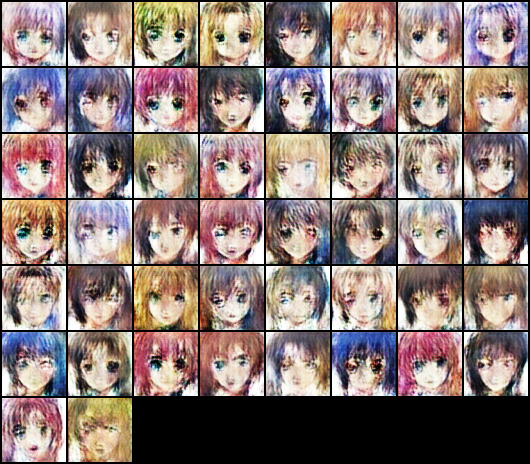

In [147]:
Image('Generated Images\generated-0001.png')

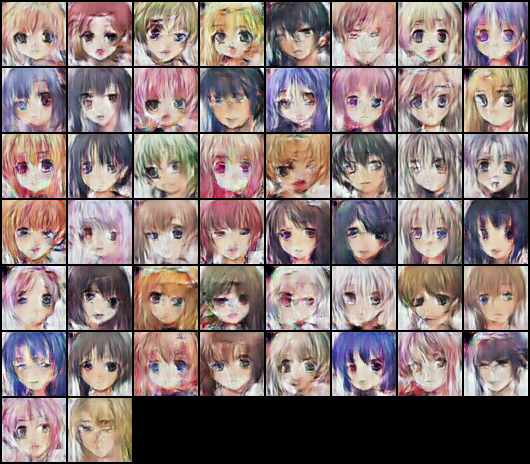

In [148]:
Image('Generated Images\generated-0005.png')

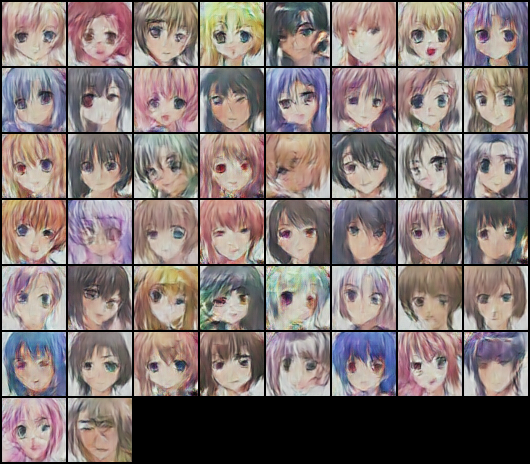

In [149]:
Image('Generated Images\generated-0010.png')

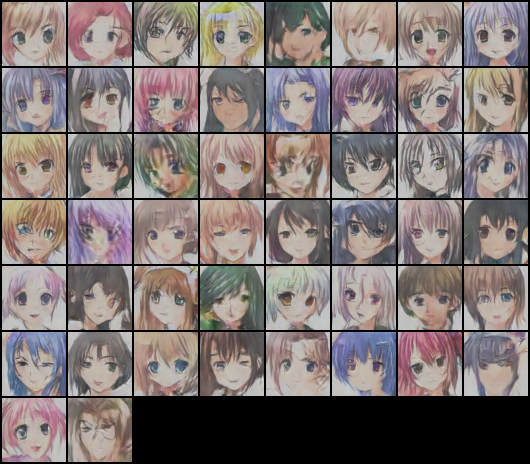

In [143]:
Image('Generated Images\generated-0025.png')

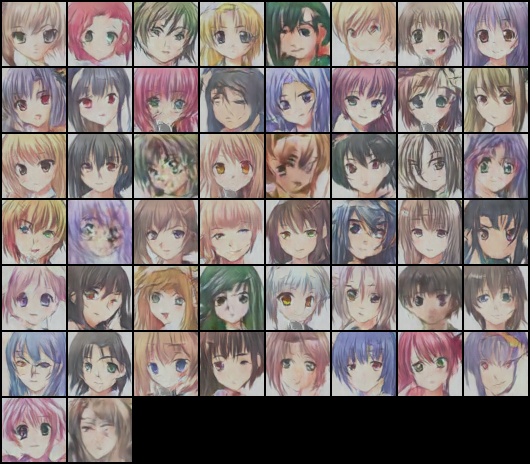

In [144]:
Image('Generated Images\generated-0050.png')

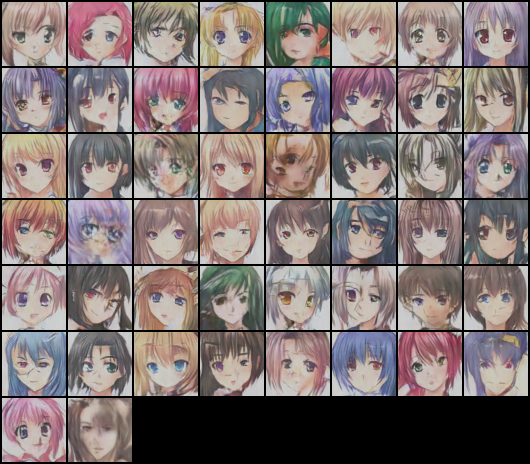

In [145]:
Image('Generated Images\generated-0070.png')

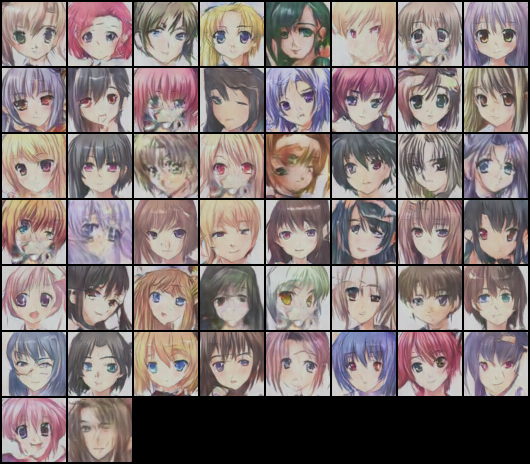

In [146]:
Image('Generated Images\generated-0100.png')

In [137]:
import os
sample_dir = 'Generated Images'
import cv2

# MAke video of the generated images
image_folder = sample_dir
video_name = 'Training.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

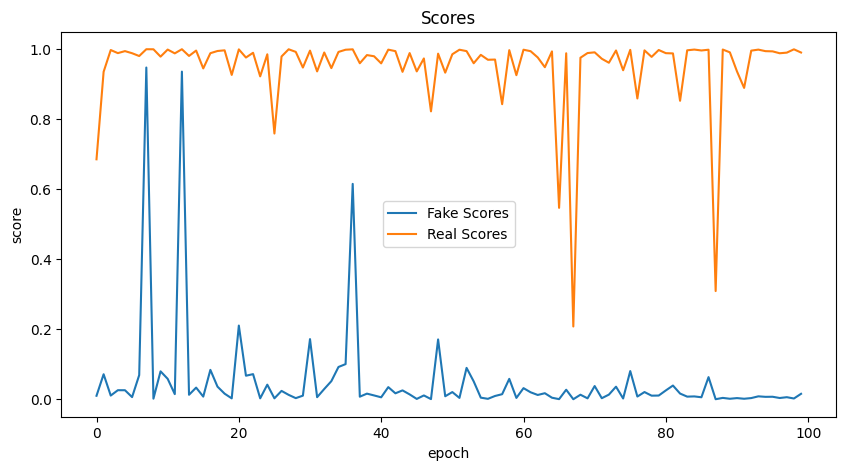

In [138]:
# Plotting the scores
plt.figure(figsize=(10,5))
plt.title("Scores")
plt.plot(fake_scores,label="Fake Scores")
plt.plot(real_scores,label="Real Scores")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend()
plt.show()

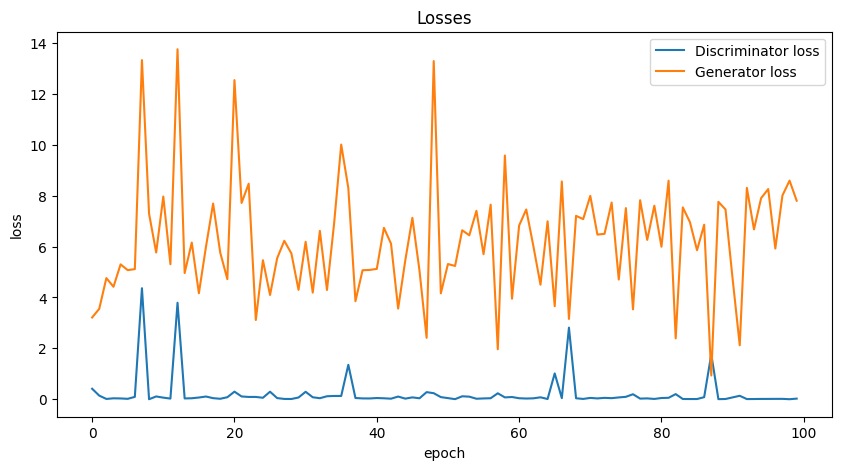

In [139]:
# Plotting the Losses
plt.figure(figsize=(10,5))
plt.title("Losses")
plt.plot(d_losses,label="Discriminator loss")
plt.plot(g_losses,label="Generator loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

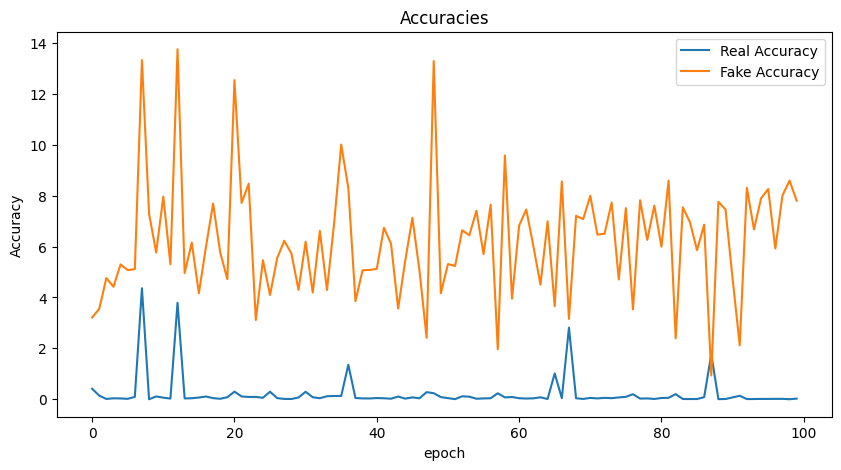

In [140]:
# Plotting the accuracies
plt.figure(figsize=(10,5))
plt.title("Accuracies")
plt.plot(d_losses,label="Real Accuracy")
plt.plot(g_losses,label="Fake Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()